# Exogenous data management

Any exogenous data can be loaded in **EOReader**. The data will be collocated onto the product grid.

Here is the way.

In [1]:
# Imports
import os

import matplotlib.pyplot as plt

from rasterio.enums import Resampling

from sertit import AnyPath
from eoreader.bands import to_str
from eoreader.reader import Reader
from eoreader.keywords import EXO_KW

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

In [3]:
# Open the product
exo_folder = AnyPath("/home/prods/EXOGENOUS")
path = exo_folder / "S2C_MSIL2A_20251017T111101_N0511_R137_T32VLM_20251017T151300.SAFE"
prod = Reader().open(path)
prod

eoreader.S2Product 'S2C_MSIL2A_20251017T111101_N0511_R137_T32VLM_20251017T151300'
Attributes:
	condensed_name: 20251017T111101_S2_T32VLM_L2A_151300
	path: /home/prods/EXOGENOUS/S2C_MSIL2A_20251017T111101_N0511_R137_T32VLM_20251017T151300.SAFE
	constellation: Sentinel-2
	sensor type: Optical
	product type: MSIL2A
	default pixel size: 10.0
	default resolution: 10.0
	acquisition datetime: 2025-10-17T11:11:01
	band mapping:
		COASTAL_AEROSOL: 01
		BLUE: 02
		GREEN: 03
		RED: 04
		VEGETATION_RED_EDGE_1: 05
		VEGETATION_RED_EDGE_2: 06
		VEGETATION_RED_EDGE_3: 07
		NIR: 08
		NARROW_NIR: 8A
		WATER_VAPOUR: 09
		SWIR_1: 11
		SWIR_2: 12
	needs extraction: False
	cloud cover: 2.722754
	tile name: T32VLM

In [4]:
# Exogenous data path
mosaic_s1 = exo_folder / "Sentinel-1_IW_mosaic_2025_M11_32VLM_0_0_VV.tif"
!gdalinfo $mosaic_s1

Driver: GTiff/GeoTIFF
Files: /home/prods/EXOGENOUS/Sentinel-1_IW_mosaic_2025_M11_32VLM_0_0_VV.tif
Size is 5004, 5004
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 32N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",9,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["m

Then you may load specific layer from the EXO folder using the `load` or `stack` function.

To do this, you need to provide the `EXO_KW`.
The expected value is a dictionnary containing the target name of the layer as key, and the `path` as sub-attribute.

In the case where the file provide as path is multi-layer, you must specify the `bandnumber` to load. Band indexes start at 1, if the band index does not exist it returns an array of nan, default: `1`.

You can also change the resampling method to apply, by using `resampler`. Supported options any Resampling value from rasterio, such as `nearest` or `bilinear`.  

In [5]:
# Load the bands
loaded_bands = prod.load(
    ['GREEN'],
    pixel_size=100.,
    **{
        EXO_KW: {'Sentinel-1_2025/11_mosaic': {'bandnumber' : 1, 'path' : mosaic_s1, 'resampler' : 'nearest'}},     
    }
)

# Display the xarray.Dataset
loaded_bands

2025-12-19 15:44:22,994 - [DEBUG] - Loading bands ['GREEN']
2025-12-19 15:44:23,008 - [DEBUG] - Read GREEN
2025-12-19 15:44:23,724 - [DEBUG] - Manage nodata for band GREEN
2025-12-19 15:44:23,827 - [DEBUG] - Converting GREEN to reflectance
/opt/conda/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2025-12-19 15:44:32,201 - [INFO] - Loading exogenous bands
2025-12-19 15:44:32,201 - [DEBUG] - EXO data info: Sentinel-1_2025/11_mosaic ; {'bandnumber': 1, 'path': PosixPath('/home/prods/EXOGENOUS/Sentinel-1_IW_mosaic_2025_M11_32VLM_0_0_VV.tif'), 'resampler': 'nearest'}
2025-12-19 15:44:32,202 - [DEBUG] - Warping EXO for 20251017T111101_S2_T32VLM_L2A_151300
2025-12-19 15:44:32,203 - [DEBUG] - Using EXO: /home/prods/EXOGENOUS/Sentinel-1_IW_mosaic_2025_M11_32VLM_0_0_VV.tif


<xarray.Dataset> Size: 10MB
Dimensions:                    (x: 1098, y: 1098, band: 1)
Coordinates:
  * x                          (x) float64 9kB 3e+05 3.002e+05 ... 4.098e+05
  * y                          (y) float64 9kB 6.7e+06 6.7e+06 ... 6.59e+06
    spatial_ref                int64 8B 0
  * band                       (band) int64 8B 1
Data variables:
    SpectralBandNames.GREEN    (band, y, x) float32 5MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Sentinel-1_2025/11_mosaic  (band, y, x) float32 5MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    long_name:         GREEN Sentinel-1_2025/11_mosaic
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /home/prods/EXOGENOUS/S2C_MSIL2A_20251017T111101_N0511...
    product_name:      S2C_MSIL2A_20251017T111101_N0511_R137_T32VLM_20251017T...
    product_filename:  S2C_MSIL2A_20251017T111101_N0511_R137_T32VLM_20251017T...
    instrument:        MSI
    product_type:      MSIL2A
    acquisition_date:  20251017T111101
    condensed_name:    20251017T111101_S2_T32VLM_L2A_151300
    orbit_direction:   DESCENDING
    cloud_cover:       2.722754

You can then access the loaded layer as you would do for any band of the product.

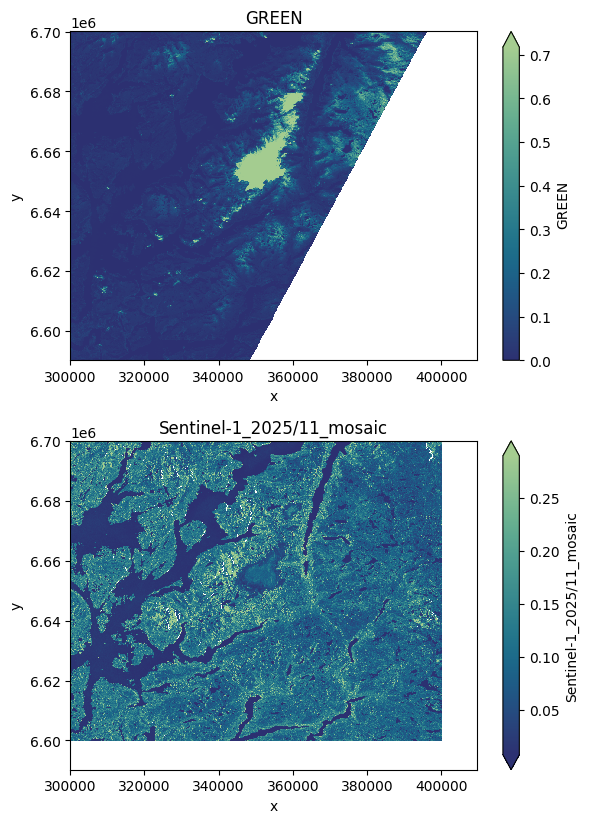

In [10]:
# Plot exogenous bands
ncols = len(loaded_bands)
plt.figure(figsize=(6, 6 * ncols), layout="tight")
i = 0
for key in loaded_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    loaded_bands[key][0, ...].plot.imshow(robust=True, cmap="crest_r")
    axes.set_title(to_str(loaded_bands[key].name)[0])
    i += 1

These arguments can be used the same way to create a stack:

In [7]:
# Stack on an AOI
stack = prod.stack(
  ['RED', 'SWIR_1'],
  pixel_size=100.,
  window=exo_folder / "aoi.shp",
  stack_path=prod.output / "stack_exo.tif",
    **{
        EXO_KW: {'Sentinel-1_2025/11_mosaic': {'path' : mosaic_s1, 'resampler' : Resampling.bilinear}},     
    }
)

2025-12-19 15:44:35,050 - [DEBUG] - Loading bands ['RED', 'SWIR_1']
2025-12-19 15:44:35,059 - [DEBUG] - Read RED
2025-12-19 15:44:35,152 - [DEBUG] - Manage nodata for band RED
2025-12-19 15:44:35,252 - [DEBUG] - Converting RED to reflectance
2025-12-19 15:44:38,524 - [DEBUG] - Read SWIR_1
2025-12-19 15:44:38,581 - [DEBUG] - Manage nodata for band SWIR_1
2025-12-19 15:44:38,660 - [DEBUG] - Converting SWIR_1 to reflectance
2025-12-19 15:44:40,535 - [INFO] - Loading exogenous bands
2025-12-19 15:44:40,536 - [DEBUG] - EXO data info: Sentinel-1_2025/11_mosaic ; {'path': PosixPath('/home/prods/EXOGENOUS/Sentinel-1_IW_mosaic_2025_M11_32VLM_0_0_VV.tif'), 'resampler': <Resampling.bilinear: 1>}
2025-12-19 15:44:40,537 - [DEBUG] - Already existing EXO for 20251017T111101_S2_T32VLM_L2A_151300. Skipping process.
2025-12-19 15:44:40,655 - [DEBUG] - Stacking
2025-12-19 15:44:40,694 - [DEBUG] - Saving stack


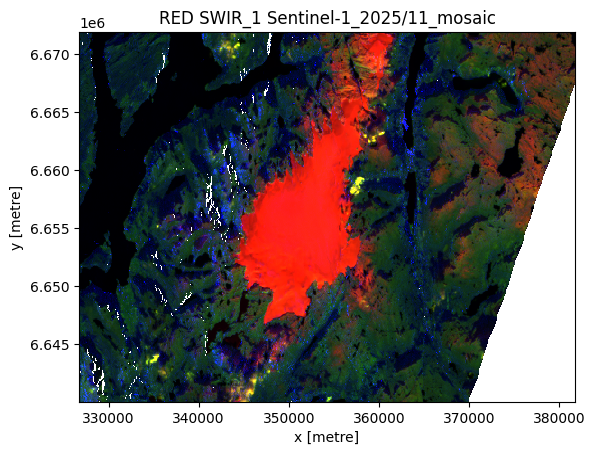

In [8]:
# Plot the stack
(stack / stack.max()).plot.imshow(robust=True)
plt.title(stack.attrs["long_name"]);

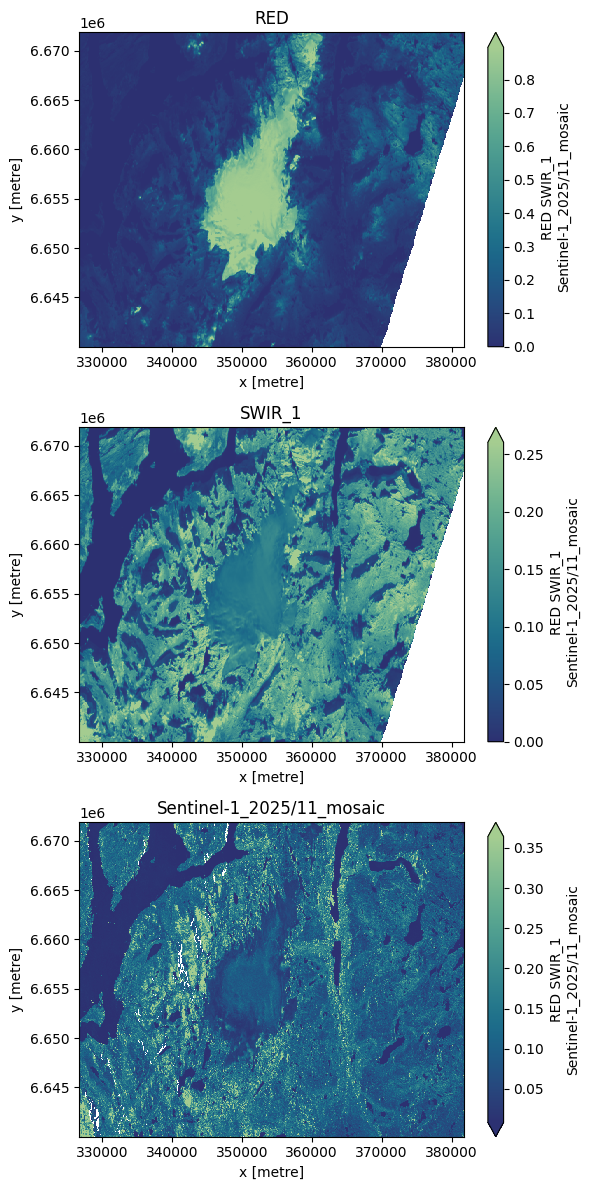

In [9]:
# Plot the stack band per band
ncols = len(stack)
band_names = stack.attrs["long_name"].split(" ")

plt.figure(figsize=(6, 4 * ncols), layout="tight")
for i in range(0, ncols):
    axes = plt.subplot(3, 1, i+1)
    stack[i, ...].plot.imshow(robust=True, cmap="crest_r")
    axes.set_title(band_names[i])
    i += 1